### **Miguel Angel Alvarez Guzman**

# Laboratorio 2

### **Cuantizacion de una señal**

**Objetivos:**

**realizar la cuantizacion de una señal ya discretizada con los siguientes parametros:**
- se usaran 6 bits, 16 para positivos y negativos, y uno para paridad
- se redondeara al mayor
- se usara el bit menos significativo para paridad
- se usara el bit mas significativo para el signo
- la señal tiene un ancho de banda de 4khz
- se muestrea a 8000 muestras/s
- cada bit dura 1/48000 segundos en la codificacion
- la codificacion se dara en señales cuadradas unipolares, bipolar, manchester y manchester diferencial
- señal informacion senosoidal 4khz +-15v



### Bloque Informacion

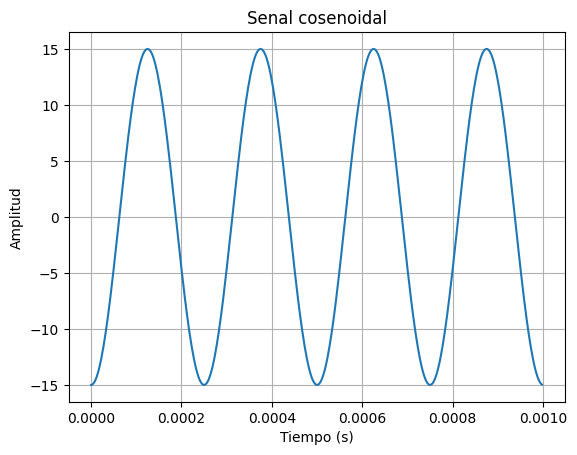

In [1]:
import numpy, scipy.special, scipy.stats
import matplotlib.pyplot as plt

# Definicion de funcion generadora de senoidal

def señal_cosenoidal(f, A=1, phi=0,     duracion=None):
    duracion = 4 / f if duracion is None else duracion
    fs = 100 * f  # frecuencia de muestreo
    t = numpy.arange(0, duracion, 1/fs)
    x = A * numpy.cos(2 * numpy.pi * f * t )
    return t, x, fs
def señal_constante(f, A):
    fs = 100 * f  # frecuencia de muestreo
    duracion = 4 / f
    t = numpy.arange(0, duracion, 1/fs)
    x = A * numpy.ones_like(t)
    return t, x, fs
# Prueba de senal senoidal
f = 4000      # frecuencia de la senal
A = -15      # amplitud de la senal
ta, xa, fs = señal_cosenoidal(f, A)
plt.figure()
plt.plot(ta, xa)
plt.title('Senal cosenoidal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

# funcion para aplicacion de transformada de Fourier a senoidal
def aplicar_fft(x, fs):
    N = len(x)
    X = numpy.fft.fft(x)
    X = numpy.fft.fftshift(X)  # centrar la FFT
    f = numpy.fft.fftfreq(N, 1/fs)
    f = numpy.fft.fftshift(f)  # centrar las frecuencias
    return f, X

### Parte Muestreo

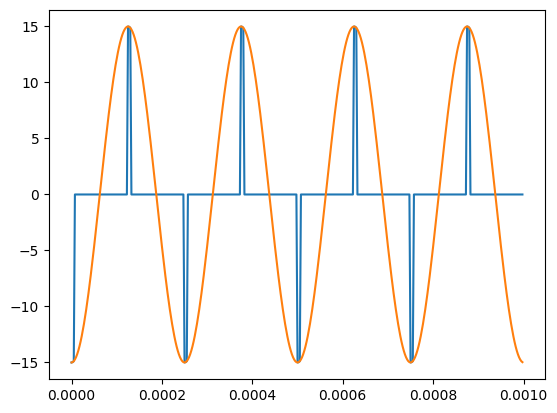

In [2]:
def modulacion_mult(f1, f2, A1=1, A2=1, duty_cycle=0.5):
    # Duracion de 4 ciclos de la senal de menor frecuencia
    duracion = 4 / f
    fs = 100 * f  # frecuencia de muestreo
    t = numpy.arange(0, duracion, 1/fs)
    x1 = xa
    x2 = A2 * scipy.signal.square(2 * numpy.pi * f2 * t, duty=duty_cycle)+A2
    x = x1 * x2
    return t, x
# Prueba de modulacion
t, x = modulacion_mult(4000,8000,15,0.5,0.05)
plt.figure()
plt.plot(t, x)
plt.plot(ta,xa)
plt.show()


### Parte Cuantizacion

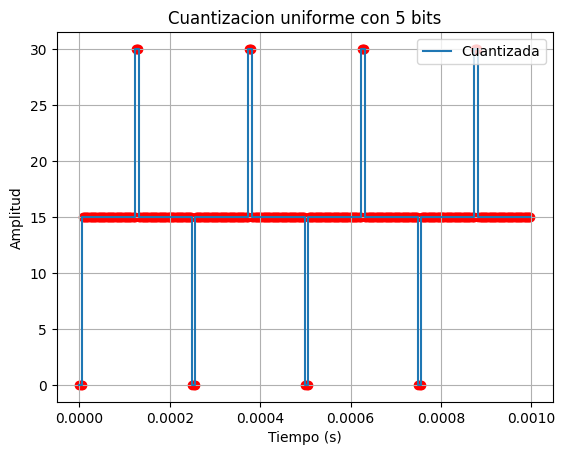

In [3]:
# Se toma el valor maximo por intervalos de la muestreada y se le asigna el valor del tiempo, la cuantizacion
# se deve hacer usando el bit mas significativo como el signo, el menos significativo como paridad par y el byte 0x00 como 0

def cuantizacion_uniforme(x, num_bits):
    # Numero de niveles de cuantizacion
    L = 2 ** num_bits
    # Rango de la senal
    x_min = numpy.min(x)
    x_max = numpy.max(x)
    # Paso de cuantizacion
    delta = (x_max - x_min) / L
    # Niveles de cuantizacion
    niveles = numpy.linspace(x_min + delta/2, x_max - delta/2, L)
    # Cuantizacion
    x_cuantizada = numpy.zeros_like(x)
    for i in range(len(x)):
        indice = int((x[i] - x_min) / delta)
        if indice < 0:
            indice = 0
        elif indice >= L:
            indice = L - 1
        x_cuantizada[i] = niveles[indice]
    # convertir niveles a enteros de num_bits bits
    x_cuantizada = ((x_cuantizada - x_min) / (x_max - x_min) * (2**num_bits - 1)).astype(int)
    return x_cuantizada
# Prueba de cuantizacion uniforme
num_bits = 5
x_cuantizada = cuantizacion_uniforme(x, num_bits)
plt.figure()
#plt.plot(t, x, label='Original')
plt.step(t, x_cuantizada, label='Cuantizada', where='mid')
plt.scatter(t, x_cuantizada, color='red')
plt.title('Cuantizacion uniforme con {} bits'.format(num_bits))
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()





### Codificacion de linea

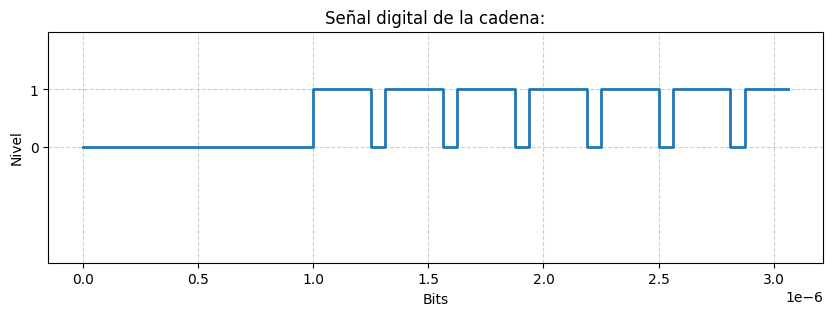

In [4]:
# se realiza codificacion de la codificacion en formatos unipolares, bipolar, manchester y manchester diferencial
def agregar_paridad_1_bit(x_cuantizada, num_bits):
    x_paridad = numpy.zeros(len(x_cuantizada), dtype=int)
    for i in range(len(x_cuantizada)):
        byte = x_cuantizada[i]
        paridad = bin(byte).count('1') % 2  # paridad par
        byte = (byte << 1) | paridad  # agregar bit de paridad al final
        x_paridad[i] = byte
    return x_paridad
def codificacion_polar_retorno_cero(x_cuantizada, num_bits):
    # Convertir a binario
    x_binario = [numpy.binary_repr(val, width=num_bits) for val in x_cuantizada]
    # Codificacion bipolar con retorno a cero
    x_bipolar_retorno_cero = []
    for byte in x_binario:
        for bit in byte:
            if bit == '1':
                x_bipolar_retorno_cero.append(1)
                x_bipolar_retorno_cero.append(0)
            else:
                x_bipolar_retorno_cero.append(-1)
                x_bipolar_retorno_cero.append(0)
    return x_bipolar_retorno_cero
def codificacion_unipolar(x_cuantizada, num_bits):
    # Convertir a binario
    x_binario = [numpy.binary_repr(val, width=num_bits) for val in x_cuantizada]
    # Codificacion unipolar
    x_unipolar = []
    for byte in x_binario:
        for bit in byte:
            if bit == '1':
                x_unipolar.append(1)
            else:
                x_unipolar.append(0)
    return x_unipolar
def codificacion_polar(x_cuantizada, num_bits):
    # Convertir a binario
    x_binario = [numpy.binary_repr(val, width=num_bits) for val in x_cuantizada]
    # Codificacion bipolar
    x_bipolar = []
    for byte in x_binario:
        for bit in byte:
            if bit == '1':
                x_bipolar.append(1)
            else:
                x_bipolar.append(-1)
    return x_bipolar
def codificacion_manchester(x_cuantizada, num_bits):
    # Convertir a binario
    x_binario = [numpy.binary_repr(val, width=num_bits) for val in x_cuantizada]
    # Codificacion manchester
    x_manchester = []
    for byte in x_binario:
        for bit in byte:
            if bit == '1':
                x_manchester.append(1)
                x_manchester.append(-1)
            else:
                x_manchester.append(-1)
                x_manchester.append(1)
    return x_manchester
def codificacion_manchester_diferencial(x_cuantizada, num_bits):
    # Convertir a binario
    x_binario = [numpy.binary_repr(val, width=num_bits) for val in x_cuantizada]
    # Codificacion manchester diferencial
    x_manchester_diff = []
    ultimo_bit = -1  # suponer que el ultimo bit fue -1
    for byte in x_binario:
        for bit in byte:
            if bit == '1':
                ultimo_bit = -ultimo_bit
                x_manchester_diff.append(ultimo_bit)
                x_manchester_diff.append(-ultimo_bit)
            else:
                x_manchester_diff.append(ultimo_bit)
                x_manchester_diff.append(-ultimo_bit)
    return x_manchester_diff
def codificacion_AMI(x_cuantizada, num_bits):
    # Convertir a binario
    x_binario = [numpy.binary_repr(val, width=num_bits) for val in x_cuantizada]
    # Codificacion AMI
    x_AMI = []
    ultimo_bit = -1  # suponer que el ultimo bit fue -1
    for byte in x_binario:
        for bit in byte:
            if bit == '1':
                ultimo_bit = -ultimo_bit
                x_AMI.append(ultimo_bit)
                x_AMI.append(ultimo_bit)
            else:
                x_AMI.append(0)
                x_AMI.append(0)
    return x_AMI
def codificacion_unipolar_vuelta_cero(x_cuantizada, num_bits):
    # Convertir a binario
    x_binario = [numpy.binary_repr(val, width=num_bits) for val in x_cuantizada]
    # Codificacion unipolar con retorno a cero
    x_unipolar_retorno_cero = []
    for byte in x_binario:
        for bit in byte:
            if bit == '1':
                x_unipolar_retorno_cero.append(1)
                x_unipolar_retorno_cero.append(0)
            else:
                x_unipolar_retorno_cero.append(0)
                x_unipolar_retorno_cero.append(0)
    return x_unipolar_retorno_cero
def codificacion_polar_retorno_cero(x_cuantizada, num_bits):
    # Convertir a binario
    x_binario = [numpy.binary_repr(val, width=num_bits) for val in x_cuantizada]
    # Codificacion bipolar con retorno a cero
    x_bipolar_retorno_cero = []
    for byte in x_binario:
        for bit in byte:
            if bit == '1':
                x_bipolar_retorno_cero.append(1)
                x_bipolar_retorno_cero.append(0)
            else:
                x_bipolar_retorno_cero.append(-1)
                x_bipolar_retorno_cero.append(0)
    return x_bipolar_retorno_cero
# Prueba de codificacion
x_paridad = agregar_paridad_1_bit(x_cuantizada, num_bits)
x_paridad = x_cuantizada
x_unipolar = codificacion_unipolar(x_paridad, num_bits)
x_bi_vuelta_cero = codificacion_unipolar_vuelta_cero(x_paridad, num_bits+1)
x_polar = codificacion_polar(x_paridad, num_bits+1)
x_polar_vuelta_cero = codificacion_polar_retorno_cero(x_paridad, num_bits+1)
x_AMI = codificacion_AMI(x_paridad, num_bits+1)
x_manchester = codificacion_manchester(x_paridad, num_bits+1)
x_manchester_diff = codificacion_manchester_diferencial(x_paridad, num_bits+1)
tiempo_unipolar = numpy.arange(0, len(x_unipolar)) * (1/(1000*f*4))  # ajustar el tiempo a la nueva tasa de bits

#Grafica de codificacion unipolar

x_Codificacion= x_unipolar
plt.figure(figsize=(10, 3))
plt.step(tiempo_unipolar[:50], x_Codificacion[:50], where='post', linewidth=2)
plt.ylim(-2, 2)
plt.yticks([0, 1])
plt.xlabel('Bits')
plt.ylabel('Nivel')
plt.title(f'Señal digital de la cadena:')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.show()

### Creacion del canal

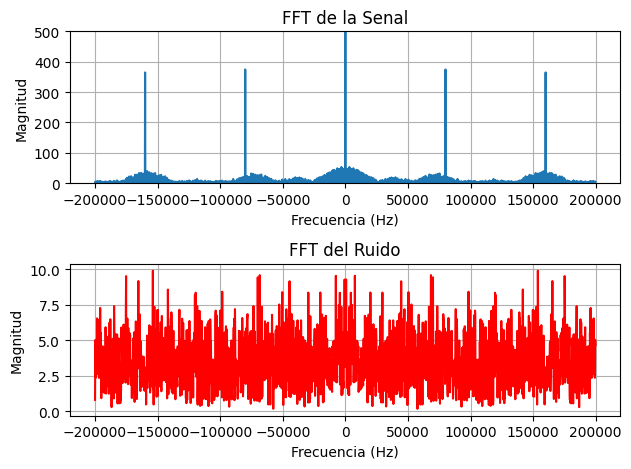

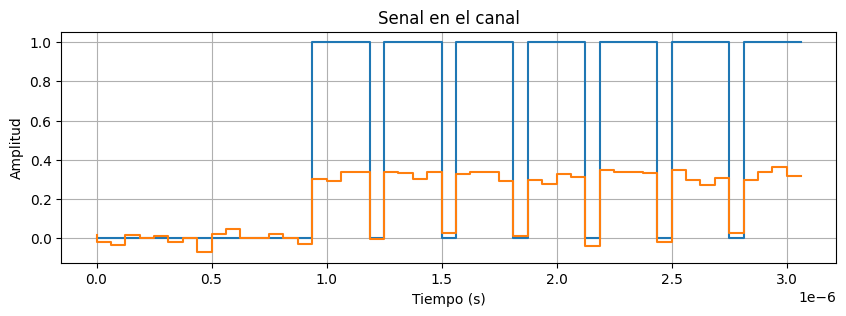

In [5]:
# Se debe simular un canal que contenga un LPF, atenuacion y ruido gaussiano
### Creacion del canal
from scipy.signal import lfilter
def filtro_LTF(f_c, fs, orden=5):
    # f_c: frecuencia de corte
    # fs: frecuencia de muestreo
    # orden: orden del filtro
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * fs
    normal_cutoff = f_c / nyquist
    b, a = butter(orden, normal_cutoff, btype='low', analog=False)
    return b, a
# Aplicacion de filtro LTF a senal modulada
def aplicar_filtro(x, b, a):
    y = lfilter(b, a, x)
    return y
def crear_canal(x, fs, fc, atenuacion_db, snr_db=20):
    # Filtro LTF
    b, a = filtro_LTF(fc, fs)
    x_filtrada = aplicar_filtro(x, b, a)
    # Atenuacion
    x_ruidos = agregar_ruido_gaussiano(x_filtrada, snr_db)  # SNR de 20 dB
    atenuacion = 10 ** (atenuacion_db / 20)
    X_atenuada = x_ruidos * atenuacion

    return X_atenuada
# Adicion de ruido gaussiano
def agregar_ruido_gaussiano(x, snr_db):
    # Calcular potencia de la señal
    potencia_senal = numpy.mean(x**2)
    # Calcular potencia del ruido
    snr = 10 ** (snr_db / 10)
    potencia_ruido = potencia_senal / snr
    # Generar ruido gaussiano hasta 800 Mhz
    ruido = numpy.random.normal(0, numpy.sqrt(potencia_ruido), len(x))
    # Señal con ruido
    x_ruidosa = x + ruido
    #Graficacion FFT del Ruido
    f, X = aplicar_fft(x_ruidosa, fs)
    f_ruido, R = aplicar_fft(ruido, fs)
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(f, numpy.abs(X), label='Senal')
    plt.title('FFT de la Senal')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    plt.ylim(0, 500)
    plt.grid()
    plt.subplot(2,1,2)
    plt.plot(f_ruido, numpy.abs(R), label='Ruido', color='red')
    plt.title('FFT del Ruido')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    plt.grid()
    plt.tight_layout()
    plt.show()
    return x_ruidosa
# Prueba de canal
fs2 = fs*5  # frecuencia de muestreo
fc = fs2/2-100  # frecuencia de corte del filtro


#aplicar el canal a la señal con codificacion unipolar
x_canal = crear_canal(x_Codificacion, fs2, fc, atenuacion_db= -10 , snr_db=20)
plt.figure(figsize=(10, 3))
longitud=int(len(t)/50)
tempo=625
plt.step(tiempo_unipolar[:50],x_Codificacion[:50], label='Senal unipolar')
plt.step(tiempo_unipolar[:50],x_canal[:50], label='Senal en el canal')
plt.title('Senal en el canal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()


### Recepcion Señal


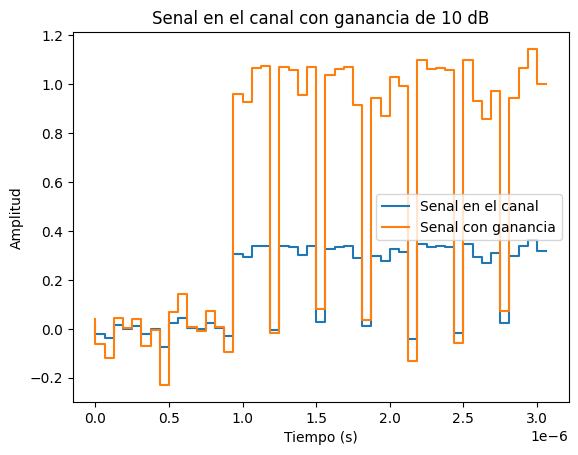

Frecuencia 3200000


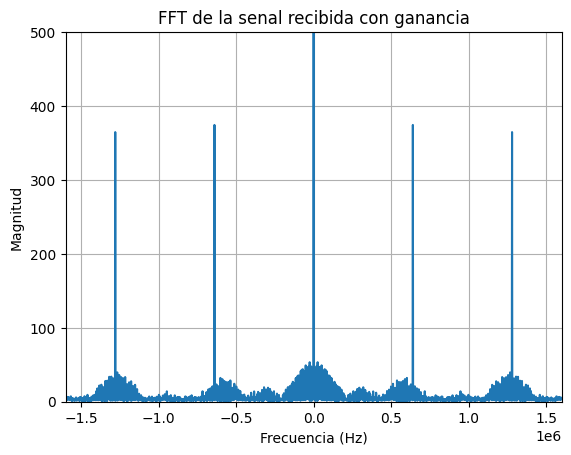

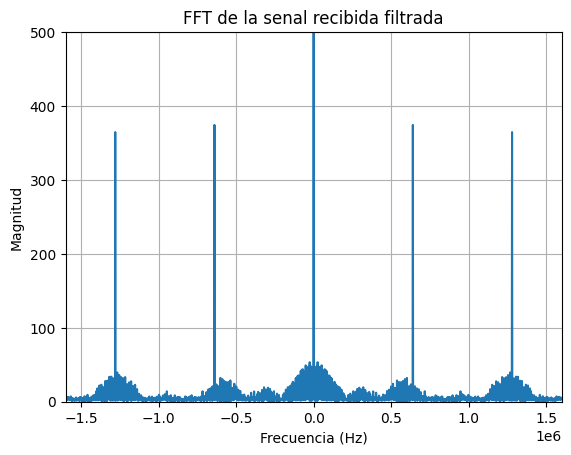

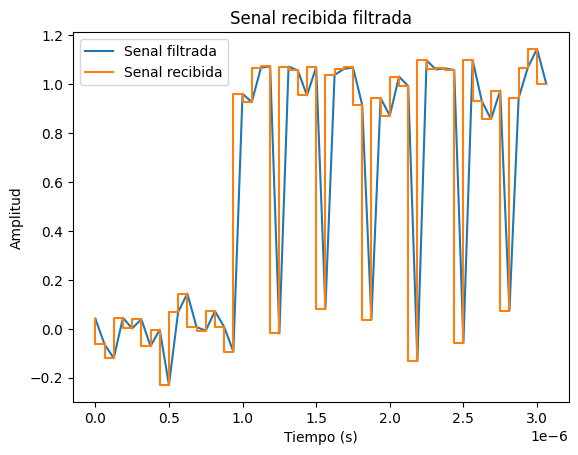

In [6]:
# Ganacia a la señal en 10 db
ganancia_db=10
x_recibida_ganancia = x_canal * (10 ** (ganancia_db / 20))
plt.figure()
plt.step(tiempo_unipolar[:50],x_canal[:50], label='Senal en el canal')
plt.step(tiempo_unipolar[:50],x_recibida_ganancia[:50], label='Senal con ganancia')
plt.title('Senal en el canal con ganancia de {} dB'.format(ganancia_db))
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

#Filtrado de la señal recibida
fs3=1600000*2
print("Frecuencia",fs3)
fc=1599999
b, a = filtro_LTF(fc, fs3)


#Graficar FFT de la señal recibida
f_recibida, X_recibida = aplicar_fft(x_recibida_ganancia, fs3)
plt.figure()
plt.plot(f_recibida, numpy.abs(X_recibida))
plt.title('FFT de la senal recibida con ganancia')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.xlim(-fs3/2, fs3/2)
plt.ylim(0, 500)
plt.grid()
plt.show()

# FFT X_unipolar
# Graficar fft de la aplicacion del filtro
x_recibida_filtrada = aplicar_filtro(x_recibida_ganancia, b, a)
f_filtrada, X_filtrada = aplicar_fft(x_recibida_filtrada, fs3)
plt.figure()
plt.plot(f_filtrada, numpy.abs(X_filtrada))
plt.title('FFT de la senal recibida filtrada')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.xlim(-fs3/2, fs3/2)
plt.ylim(0, 500)
plt.grid()
plt.show()
plt.figure()

plt.plot(tiempo_unipolar[:50],x_recibida_filtrada[:50], label='Senal filtrada')
plt.step(tiempo_unipolar[:50],x_recibida_ganancia[:50], label='Senal recibida')
plt.title('Senal recibida filtrada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

### Decodificar la señal

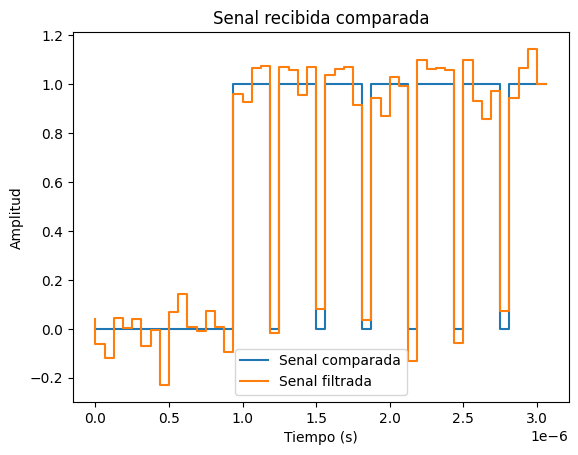

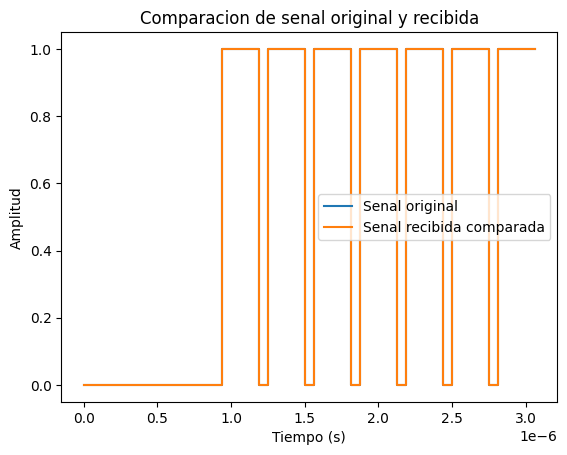

In [7]:
# Aplcar un comparador para recuperar la senal digital
def comparador(x, umbral=0):
    x_comparada = numpy.zeros_like(x)
    for i in range(len(x)):
        if x[i] > umbral:
            x_comparada[i] = 1
        else:
            x_comparada[i] = 0
    return x_comparada
x_recibida_comparada = comparador(x_recibida_filtrada, umbral=0.3)
plt.figure()
plt.step(tiempo_unipolar[:50],x_recibida_comparada[:50], label='Senal comparada')
plt.step(tiempo_unipolar[:50],x_recibida_filtrada[:50], label='Senal filtrada')
plt.title('Senal recibida comparada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

# Comparacion con la original en subplots
plt.figure()
plt.step(tiempo_unipolar[:50],x_unipolar[:50], label='Senal original')
plt.step(tiempo_unipolar[:50],x_recibida_comparada[:50], label='Senal recibida comparada')
plt.title('Comparacion de senal original y recibida')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.show()


# Decodificacion

Señal decodificada (primeros 10 valores):
[ 0  0  0 15 15 15 15 15 15 15]


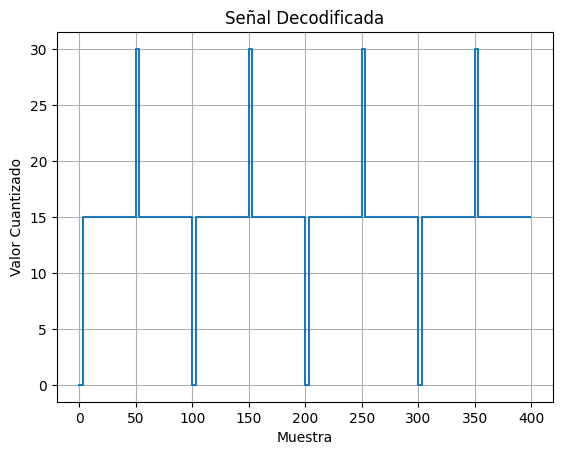

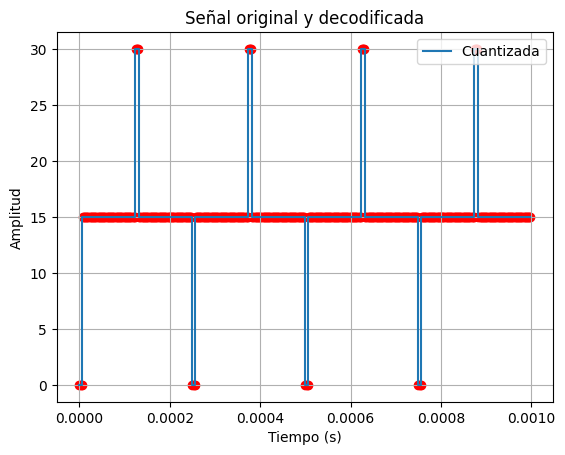

In [8]:
def decodificar_binario(x_comparada, num_bits):
    # Convertir la señal comparada a una cadena binaria
    x_binario_str = ''.join(map(str, x_comparada.astype(int)))

    # Dividir la cadena binaria en grupos de num_bits
    bytes_binarios = [x_binario_str[i:i+num_bits] for i in range(0, len(x_binario_str), num_bits)]

    # Convertir cada byte binario a decimal
    x_decodificada = numpy.array([int(byte, 2) for byte in bytes_binarios])

    return x_decodificada

# Decodificar la señal recibida comparada
x_decodificada = decodificar_binario(x_recibida_comparada, num_bits)

# Mostrar la señal decodificada (primeros 10 valores)
print("Señal decodificada (primeros 10 valores):")
print(x_decodificada[:10])

# Opcional: Graficar la señal decodificada (escalonada)
plt.figure()
plt.step(numpy.arange(len(x_decodificada)), x_decodificada, where='post')
plt.title('Señal Decodificada')
plt.xlabel('Muestra')
plt.ylabel('Valor Cuantizado')
plt.grid(True)
plt.show()

plt.figure()
plt.step(t, x_cuantizada, label='Cuantizada', where='mid')
plt.scatter(t, x_cuantizada, color='red')
plt.title('Señal original y decodificada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()


# Convertir a valores de amplitud

Señal recuperada en amplitud (primeros 10 valores):
[-14.53125 -14.53125 -14.53125  -0.46875  -0.46875  -0.46875  -0.46875
  -0.46875  -0.46875  -0.46875]


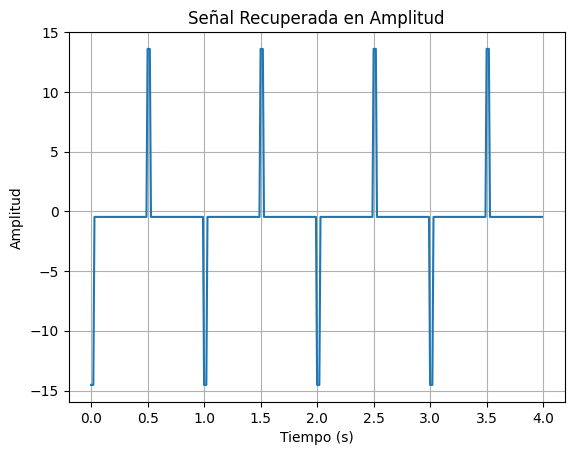

In [9]:
def convertir_a_amplitud(x_decodificada, x_min, x_max, num_bits):
    # Numero de niveles de cuantizacion
    L = 2 ** num_bits
    # Paso de cuantizacion
    delta = (x_max - x_min) / L
    # Convertir los valores decodificados a amplitud
    x_amplitud = x_decodificada * delta + x_min + delta/2
    return x_amplitud

# Convertir la señal decodificada a valores de amplitud
x_recuperada_amplitud = convertir_a_amplitud(x_decodificada, -15, 15, num_bits)

# Mostrar la señal recuperada en amplitud (primeros 10 valores)
print("Señal recuperada en amplitud (primeros 10 valores):")
print(x_recuperada_amplitud[:10])

# Graficar la señal recuperada en amplitud
plt.figure()
plt.plot(numpy.arange(len(x_recuperada_amplitud)) / (fs / f), x_recuperada_amplitud) # Ajustar el eje x al tiempo original
plt.title('Señal Recuperada en Amplitud')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()


# Aplicar Filtro Pasa Bajos


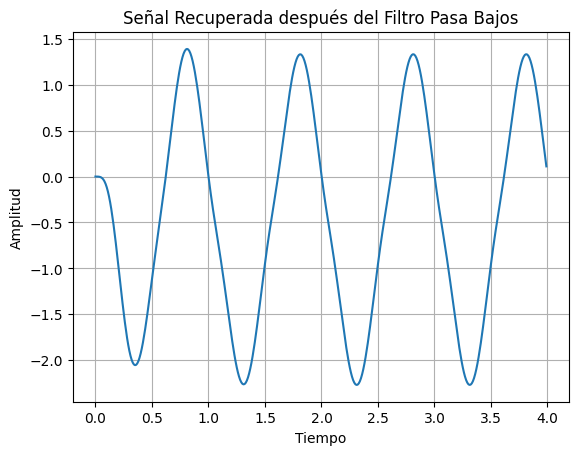

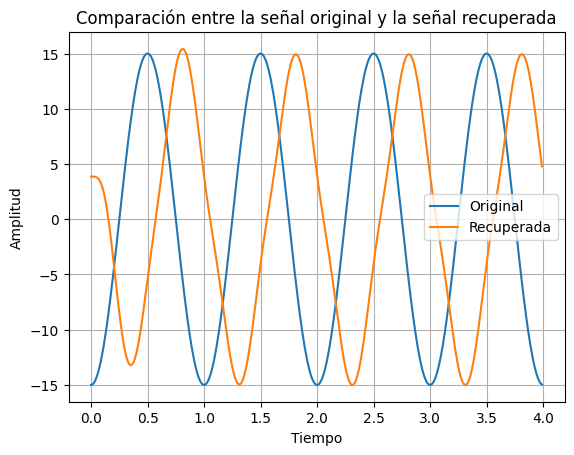

In [10]:
# Crea una funcion para aplicar un filtro pasa bajos a la señal resultante para asi recuperar la original
def aplicar_filtro_pasa_bajos_recuperacion(x_decodificada, fs, fc_recuperacion):
    b, a = filtro_LTF(fc_recuperacion, fs)
    x_recuperada_filtrada = aplicar_filtro(x_decodificada, b, a)
    return x_recuperada_filtrada

# Aplicar el filtro pasa bajos a la señal decodificada
# Debes definir una frecuencia de corte adecuada para la recuperacion (fc_recuperacion)
# Por ejemplo, la frecuencia de la señal original (f)
fc_recuperacion = 0.9*f*2  # Usar la frecuencia de la señal original como frecuencia de corte

x_recuperada = aplicar_filtro_pasa_bajos_recuperacion(x_recuperada_amplitud, fs, fc_recuperacion)

# Graficar la señal recuperada
plt.figure()
plt.plot(numpy.arange(len(x_recuperada)) / (fs / f), x_recuperada) # Ajustar el eje x al tiempo original
plt.title('Señal Recuperada después del Filtro Pasa Bajos')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

# Normalizar a -15 y 15
x_recuperada = (x_recuperada - numpy.min(x_recuperada)) / (numpy.max(x_recuperada-0.05) - numpy.min(x_recuperada)) * 30 - 15
# Comparar con la original
plt.figure()
plt.plot(numpy.arange(len(x)) / (fs / f), xa, label='Original')
plt.plot(numpy.arange(len(x_recuperada)) / (fs / f), x_recuperada, label='Recuperada')
plt.title('Comparación entre la señal original y la señal recuperada')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()
